In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import json

from feature_extractor import FeatureExtractor

## get label distribution

In [11]:
anno_dict = pickle.load(open('/workspace/pvc-meteor/features/annotations.pickle', 'rb'))
anno_dict['REC_2020_10_12_03_08_38_F.MP4']['feature_length'] == anno_dict['REC_2020_10_12_03_08_38_F.MP4']['anno'].shape[0]

True

In [7]:
total_frames = 0
cat_array = np.zeros((7,))
unannoted_frames = 0

for name in tqdm(out_dict.keys()):
    total_frames += out_dict[name]['feature_length']
    annotation = out_dict[name]['anno']
    new_cat = np.sum(annotation, axis=0)
    unannoted_frames += out_dict[name]['feature_length'] - np.any(annotation, axis=1).sum()

    cat_array = cat_array + new_cat


100%|██████████| 1213/1213 [00:00<00:00, 11239.49it/s]


In [8]:
cat_list = cat_array.tolist()
cat_list[2] - total_frames

-895175.0

In [11]:
cat_names = ['Over Taking', 'Over Speedign', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']

cat_list, total_frames, unannoted_frames

([281774.0, 342.0, 90571.0, 518.0, 36512.0, 213.0, 9482.0], 985746, 622239)

### generate `pos_weight` for `torch.nn.BCEWithLogitsLoss`

In [41]:
df = (
    pd.DataFrame(
    data=cat_list,
    columns=['frames_per_cat'],
    index=cat_names
    )
    .assign(frames_not_cat = total_frames - df.iloc[:,0])
    .assign(weight = df.loc[:, 'frames_not_cat'] / df.iloc[:, 0])
    )
df

,frames_per_cat,frames_not_cat,weight
Over Taking,281774.0,703972.0,2.498357
Over Speedign,342.0,985404.0,2881.298246
Lane Change,90571.0,895175.0,9.883682
Traffic Light,518.0,985228.0,1901.984556
Wrong Lane,36512.0,949234.0,25.997864
Wrong Turn,213.0,985533.0,4626.915493
Cutting,9482.0,976264.0,102.959713


In [60]:
torch.tensor(df.weight.values)

tensor([2.4984e+00, 2.8813e+03, 9.8837e+00, 1.9020e+03, 2.5998e+01, 4.6269e+03,
        1.0296e+02], dtype=torch.float64)

## visualize class distribution

Text(0.5, 1.0, 'Distribution of frames per category')

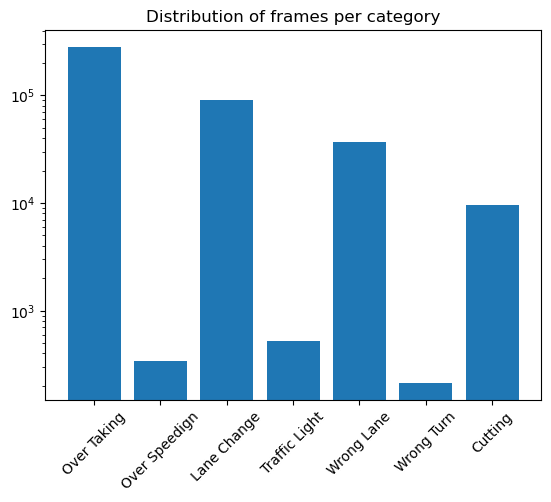

In [21]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
cat_names = ['Over Taking', 'Over Speeding', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']


ax.bar(cat_names, cat_list)
plt.xticks(rotation = 45)
plt.title('Distribution of frames per category, Logscaled')

### analyse test and train set seperately.

In [18]:
json_file = json.load(open('../../pvc-meteor/features/METEOR_info.json', 'r'))['METEOR']

In [23]:
train_vid_names = json_file['train_session_set']
test_vid_names = json_file['test_session_set']

test_class_counts = np.zeros((7))
for vid_name in test_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    test_class_counts = test_class_counts + np.sum(curr_anno, axis=0)
    
train_class_counts = np.zeros((7))
for vid_name in train_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    train_class_counts = train_class_counts + np.sum(curr_anno, axis=0) 

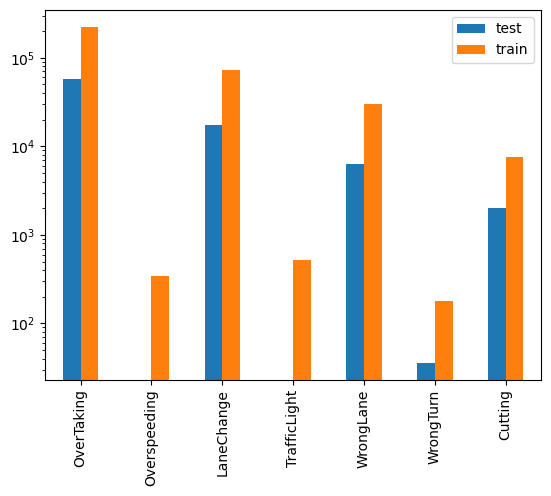

In [31]:
df = pd.DataFrame(
    data=np.column_stack((test_class_counts, train_class_counts)),
    columns=['test', 'train'],
    index = json_file['class_index']
)

ax = df.plot(kind='bar', stacked=False)
ax.set_yscale('log')